In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils



# load file
df = pd.read_csv('train.csv')

# drop columns not required for training
df = df.drop(['transaction_id','InvoiceDate','customer_id'], axis = 1)

# filter data for 21 products
df = df[df.item_id.isin(['20724','20725','20726','20727','20728','20914','21080','21212','21232',
'21754','21790','21931','21977','22178','22197','22355','84879','84991',
'85099B','85099C','85123A'])].reset_index(drop=True)

# remove negative item_qty records
df = df[df.item_qty >0]

In [19]:
df

,item_id,item_qty,item_amt
0,85123A,6,2.55
1,84879,32,1.69
2,21754,3,5.95
3,85123A,6,2.55
4,85123A,6,2.55
...,...,...,...
47374,20724,10,0.85
47375,85099B,20,1.95
47376,84879,16,1.69
47377,20914,24,2.95


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


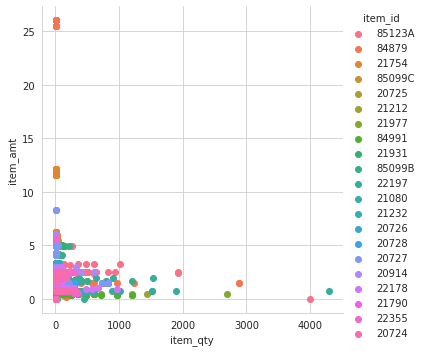

In [20]:
# plot to see outliers and high leverage points

# percent seems on these seems very less and so NN model will be robust to these
df_plot = df
sns.set_style('whitegrid');
sns.FacetGrid(df_plot, hue='item_id', size=5) \
.map(plt.scatter, 'item_qty', 'item_amt') \
.add_legend();
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


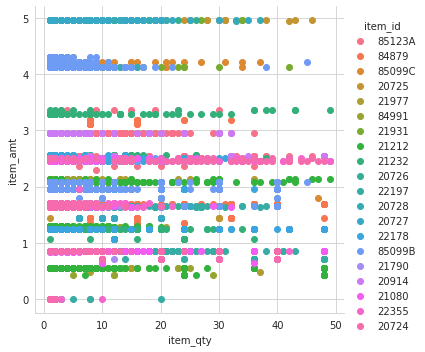

In [21]:
# plot to see distinguishable products
df_plot = df[(df.item_qty <50)  & (df.item_amt < 5)]
sns.set_style('whitegrid');
sns.FacetGrid(df_plot, hue='item_id', size=5) \
.map(plt.scatter, 'item_qty', 'item_amt') \
.add_legend();
plt.show()

In [22]:
# get features and labels
x_data = df.drop(['item_id'],axis=1)
y_data = df['item_id']

In [23]:
# encode labels to integers
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_y_data = encoder.transform(y_data)

# convert integers to one hot encoded values
dummy_y = np_utils.to_categorical(encoded_y_data)

print('Number of labels: ',len(dummy_y[0]))
print('Example: ',dummy_y[0])

Number of labels:  21
Example:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [24]:
# convert to numpy array to feed to neural network
x_data = np.array(x_data)

In [25]:
# split into train test
X_train, X_test, y_train, y_test = train_test_split(x_data, dummy_y,test_size=0.1, random_state = 1)

In [26]:
# build our model
model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1],), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(21, activation='softmax'))
model.summary()

# compile model with optimizers, loss and metrics
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                150       
                                                                 
 dense_3 (Dense)             (None, 21)                1071      
                                                                 
Total params: 1,221
Trainable params: 1,221
Non-trainable params: 0
_________________________________________________________________


In [27]:
# early stopping
es = EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True)


# start training the model
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=100,
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
3343/3343 [==============================] - 8s 2ms/step - loss: 2.7663 - accuracy: 0.1693 - val_loss: 2.5543 - val_accuracy: 0.2015
Epoch 2/100
3343/3343 [==============================] - 7s 2ms/step - loss: 2.3876 - accuracy: 0.2628 - val_loss: 2.3270 - val_accuracy: 0.3202
Epoch 3/100
3343/3343 [==============================] - 7s 2ms/step - loss: 2.2581 - accuracy: 0.2947 - val_loss: 2.2556 - val_accuracy: 0.3261
Epoch 4/100
3343/3343 [==============================] - 7s 2ms/step - loss: 2.1753 - accuracy: 0.3169 - val_loss: 2.1505 - val_accuracy: 0.3690
Epoch 5/100
3343/3343 [==============================] - 7s 2ms/step - loss: 2.1029 - accuracy: 0.3306 - val_loss: 2.1071 - val_accuracy: 0.3586
Epoch 6/100
3343/3343 [==============================] - 7s 2ms/step - loss: 2.0462 - accuracy: 0.3462 - val_loss: 2.0325 - val_accuracy: 0.3578
Epoch 7/100
3343/3343 [==============================] - 7s 2ms/step - loss: 1.9966 - accuracy: 0.3638 - val_loss: 2.0312 - val_ac

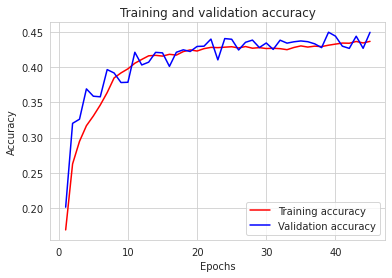

In [28]:
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
n = 10
m = n+1
preds = model.predict(X_test[n:m])
print('prediction: ',preds[0])
print('prediction probability of top three products: ',preds[0][np.argpartition(preds[0], -3)[-3:]])
print('indices of top three products: ',np.argpartition(preds[0], -3)[-3:])
print('true label: ', y_test[n:m])
print('true label 1 lndex: ', np.where(y_test[n:m] == 1)[1][0])

1/1 [==============================] - 0s 46ms/step
prediction:  [2.7630653e-02 1.0347375e-02 6.8485951e-03 1.0894540e-02 8.4884316e-03
 6.7958518e-23 3.2306958e-02 5.9408896e-02 5.3554302e-01 4.1501112e-19
 2.5309701e-02 7.5678134e-19 4.0004708e-02 1.3853087e-01 4.8204113e-02
 2.7522091e-02 8.2488468e-06 2.8951816e-02 1.5239789e-16 1.2976584e-17
 2.8804406e-18]
prediction probability of top three products:  [0.0594089  0.13853087 0.535543  ]
indices of top three products:  [ 7 13  8]
true label:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
true label 1 lndex:  7


In [30]:
# predict all test data
preds_arr = model.predict(X_test)

def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s

# get top three product indices from each prediciton based on top 3 probability scores
preds_index = [sort_index(i)[:3] for i in preds_arr]

146/146 [==============================] - 0s 1ms/step


In [31]:
# get the file for all top three predictions
pred_otp = []
for i in preds_index:
  temp = [0]*21
  for j in i:
    temp[j] = 1
  pred_otp.append(temp)

pd.DataFrame(pred_otp).to_csv('output.csv')

In [32]:
pd.DataFrame(pred_otp)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4638,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4639,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4640,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4641,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [33]:
# add index of the labels in y test
y_test_index = [list(i).index(1) for i in y_test]

In [34]:
# increase match by 1 if the y test index is in top three product indices
match = 0
for i in range(len(y_test_index)):
  if y_test_index[i] in preds_index[i]:
    match += 1


print('Performance Metric: Match Rate over 10% test data: ',(match/len(y_test_index))*100)

Performance Metric: Match Rate over 10% test data:  79.40986431186732
